# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

Data Preparation

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
# explore the profile 
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.shape

(17000, 5)

In [6]:
# To transform the feature, we create a new column
profile['member_on'] = pd.to_datetime(profile['became_member_on'].astype(str)).dt.date
profile.drop('became_member_on', 1, inplace=True)

In [7]:
profile.loc[profile['gender'].isnull()].describe()

,age,income
count,2175.0,0.0
mean,118.0,NaN
std,0.0,NaN
min,118.0,NaN
25%,118.0,NaN
50%,118.0,NaN
75%,118.0,NaN
max,118.0,NaN


In [8]:
profile = profile.loc[profile['gender'].isnull() == False]

rows, cols = profile.shape
print(f'After data preparation, we have {rows} rows and {cols} columns.\n')

After data preparation, we have 14825 rows and 5 columns.



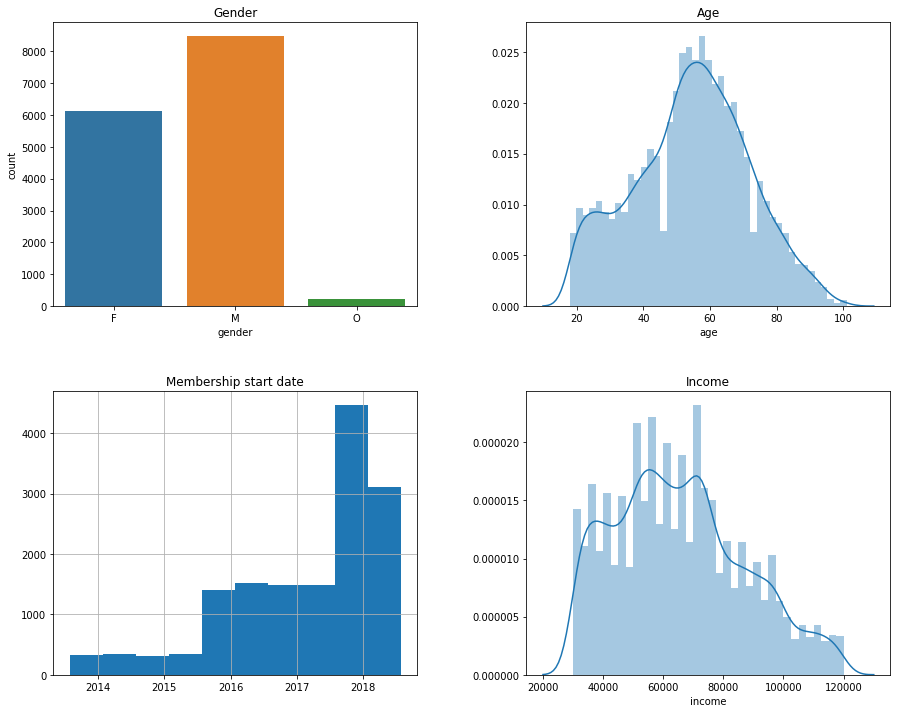


Membership start dates range from 2013-07-29 to 2018-07-26.



In [9]:
plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(221)
plt.title('Gender')
sns.countplot(x='gender', data=profile)

plt.subplot(222)
plt.title('Age')
sns.distplot(profile['age'])

plt.subplot(223)
plt.title('Membership start date')
profile['member_on'].hist()

plt.subplot(224)
plt.title('Income')
sns.distplot(profile['income'])

plt.show()


print('\nMembership start dates range from {} to {}.\n'.format(
    profile['member_on'].min().strftime('%Y-%m-%d'), profile['member_on'].max().strftime('%Y-%m-%d')
))

In [10]:
transcript.shape

(306534, 4)

In [11]:
# explore transcript
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [12]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [13]:
for k in ['reward', 'amount']:
    transcript[k] = transcript['value'].apply(lambda x: x[k] if k in x else None)
    
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
transcript.drop('value', 1, inplace=True)

In [14]:
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [15]:
cust_list = transcript.groupby('person')['time'].count()
cust_list.sort_values(ascending=False).head(3)

person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
Name: time, dtype: int64

In [16]:
transcript.loc[transcript['person'] == cust_list.index[0]].sort_values('time')

,event,person,time,reward,amount,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,22.16,None
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed
153401,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
168412,transaction,0009655768c64bdeb2e877511632db8f,414,NaN,8.57,None
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,5.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [17]:
tmp = pd.merge(transcript.loc[transcript['event'] == 'offer completed'],
               transcript.loc[transcript['event'] == 'transaction', ['person', 'event', 'time']],
               on=['person', 'time'])

print('There are {} offer completed.'.format(sum(transcript['event'] == 'offer completed')))
print('There are {} matches.'.format(tmp.shape[0]))

There are 33579 offer completed.
There are 33579 matches.


In [18]:
tmp = pd.merge(transcript.loc[transcript['event'] == 'offer viewed'].reset_index(),
               transcript.loc[transcript['event'] == 'offer received', ['person', 'time', 'offer_id']],
               on=['person', 'offer_id'])

print('There are {} offer viewed.'.format(sum(transcript['event'] == 'offer viewed')))
print('There are {} matches.'.format(len(tmp['index'].unique())))

There are 57725 offer viewed.
There are 57725 matches.


Recreating the customer's journey
To better analyse the completion of the offers, we create a new dataframe recreating the entire funnel of customer's conversion:

At first, we join the offer received with the eventual view by the customer
Then, we follow the same approach to add information about conversion (offer completed)
Finally, we add the transactions. If there's a relative offer completed, we join the information to the row; if not, we add a new row.

In [19]:
# At first, let's join togheter the received offer with the relative (eventual) view
views = pd.merge(transcript.loc[transcript['event'] == 'offer received', ['person', 'offer_id', 'time']],
                 transcript.loc[transcript['event'] == 'offer viewed', ['person', 'offer_id', 'time']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

# We have to be sure to take the reception BEFORE the view (or when there's no view)
views = views.loc[(views['time_viewed'] >= views['time_received']) | (views['time_viewed'].isnull())]

# Then we take the NEAREST reception before the view
# We concatenate with the "missing view" dataframe portion, since aggregation results in a drop of these records
views = pd.concat((views.groupby(['person', 'offer_id', 'time_viewed']).agg({'time_received': 'max'}).reset_index(),
                  views.loc[views['time_viewed'].isnull()]),
                  axis=0, sort=True)

views.head()

,offer_id,person,time_received,time_viewed
0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,336,372.0
1,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,168,192.0
2,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,408,456.0
3,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,504,540.0
4,f19421c1d4aa40978ebb69ca19b0e20d,00116118485d4dfda04fdbaba9a87b5c,168,216.0


In [20]:
# Same reasoning joining the info about offer completion
comp = pd.merge(views,
                transcript.loc[transcript['event'] == 'offer completed', ['person', 'offer_id', 'time', 'reward']],
                on=['person', 'offer_id'], how='left').rename(columns={'time': 'time_completed'})

# When the completion time is AFTER the view time, we force the value to null
comp.loc[(comp['time_viewed'].isnull()) | (comp['time_viewed'] > comp['time_completed']), ['time_completed', 'reward']] = (np.nan, np.nan)
comp.drop_duplicates(inplace=True)

comp = pd.concat(
    (comp.groupby(['person', 'offer_id', 'time_completed', 'reward']).agg({'time_viewed': 'max', 'time_received': 'max'}).reset_index(),
     comp.loc[comp['time_completed'].isnull()]),
    axis=0, sort=True
)

comp.head()

,offer_id,person,reward,time_completed,time_received,time_viewed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,5.0,576.0,408,432.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,0011e0d4e6b944f998e987f904e8c1e5,3.0,252.0,168,186.0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0011e0d4e6b944f998e987f904e8c1e5,5.0,576.0,504,516.0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,0020c2b971eb4e9188eac86d93036a77,10.0,510.0,408,426.0
4,fafdcd668e3743c1bb461111dcafc2a4,0020c2b971eb4e9188eac86d93036a77,2.0,54.0,0,12.0


In [21]:
# Now we join the information about the relative transaction
journey = pd.merge(comp,
                   transcript.loc[transcript['event'] == 'transaction', ['person', 'time', 'amount']],
                   left_on=['person', 'time_completed'], right_on=['person', 'time'], how='outer').rename(columns={'time': 'time_transaction'})

# Create a reference time - received for offer, transaction otherwise
journey['time'] = journey['time_received']
journey.loc[journey['time'].isnull(), 'time'] = journey['time_transaction']

# If an offer is completed twice, we have some duplicates: we have to remove them
journey.sort_values(['person', 'offer_id', 'time', 'time_completed'], inplace=True)
journey = journey.drop_duplicates(['person', 'offer_id', 'time'])

journey = journey[['person', 'offer_id', 'time', 'time_received', 'time_viewed', 'time_completed', 'time_transaction', 'amount', 'reward']]

rows, cols = journey.shape
print(f'There are {rows} rows and {cols} columns.\n')
journey.head()

There are 188234 rows and 9 columns.



,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward
24618,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,NaN,NaN,NaN,NaN
24614,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,336.0,372.0,NaN,NaN,NaN,NaN
24615,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,192.0,NaN,NaN,NaN,NaN
24616,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,408.0,456.0,NaN,NaN,NaN,NaN
24617,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,504.0,540.0,NaN,NaN,NaN,NaN


Joining data

Now we can join the 3 entities into one single dataset to analyse.

In [22]:
# Join offer info
tmp = pd.merge(journey,
               portfolio.rename(columns={'reward': 'pot_reward', 'id': 'offer_id'}),
               on='offer_id', how='left')

tmp.head()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,difficulty,duration,offer_type,pot_reward
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,NaN,NaN,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,336.0,372.0,NaN,NaN,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,192.0,NaN,NaN,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,408.0,456.0,NaN,NaN,NaN,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,504.0,540.0,NaN,NaN,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0


In [23]:
# Join person info
# We will lose some records since we dropped some profiles with no informations

df = pd.merge(tmp,
              profile.rename(columns={'id': 'person'}),
              how='inner', on='person')

# To better visualize the journey, let's order by the offer received time / transaction time
df.sort_values(['person', 'time', 'offer_id'], inplace=True)

# For transactions we put a specific "offer type"
df['offer_type'].fillna('transaction', inplace=True)

rows, cols = df.shape
print(f'There are {rows} rows and {cols} columns.\n')
df.head()

There are 164838 rows and 18 columns.



,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,difficulty,duration,offer_type,pot_reward,age,gender,income,member_on
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,192.0,NaN,NaN,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0,33,M,72000.0,2017-04-21
5,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,336.0,372.0,NaN,NaN,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0,33,M,72000.0,2017-04-21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,408.0,456.0,NaN,NaN,NaN,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,33,M,72000.0,2017-04-21
6,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21


In [24]:
# Write output
df.to_csv('./data/journey.csv', index=False)

Feature Engineering

In [25]:
%reload_ext autoreload
%autoreload 2
df = pd.read_csv('data/journey.csv', parse_dates=['member_on'])

# Offer received and never viewed have no interest for us, so we drop them
df = df.loc[(df['offer_type'] == 'transaction') | (df['time_viewed'].isnull() == False)]

df['time'] = df['time_viewed']
df.loc[df['offer_type'] == 'transaction', 'time'] = df['time_transaction']

df.sort_values(['person', 'time', 'offer_id'], inplace=True)

print(df.shape)
df.head()

(150435, 18)


,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,difficulty,duration,offer_type,pot_reward,age,gender,income,member_on
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.0,168.0,192.0,NaN,NaN,NaN,NaN,"['email', 'mobile', 'social']",0.0,3.0,informational,0.0,33,M,72000.0,2017-04-21
1,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,336.0,372.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile']",0.0,4.0,informational,0.0,33,M,72000.0,2017-04-21
4,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.0,408.0,456.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile', 'social']",5.0,5.0,bogo,5.0,33,M,72000.0,2017-04-21


Conversion Rate

Our goal is to predict the right type of offer for each customer, in order to grow the **Conversion Rate** (the percentage of offers *completed* on all offers). What's the actual CR? We calculate it as **benchmark** of our model.

We have to keep in mind that:
- *Informational* offers do not have a real conversion, nor a *completed offer* record. In this case, we exclude them to have a more precise benchmark.
- Only *viewed* offers can be considered, since we do not have a real *conversion* if the customer never saw the offer.

In [26]:
# Create some help flags
tmp = df.loc[:, ['offer_type', 'time_viewed', 'time_completed']]

# Flag offer viewed
tmp['flg_viewed'] = 0
tmp.loc[(tmp['offer_type'].isin(['bogo', 'discount'])) & (tmp['time_viewed'].isnull() == False), 'flg_viewed'] = 1


# Flag conversion
tmp['flg_conv'] = 0
tmp.loc[
    (tmp['offer_type'].isin(['bogo', 'discount'])) & (tmp['time_viewed'].isnull() == False) & (df['time_completed'].isnull() == False),
    'flg_conv'
] = 1

num = sum(tmp['flg_conv'])
den = sum(tmp['flg_viewed'])
print(f'There are {den} viewed offers.')
print(f'There are {num} completed offers.')
print(f'\n\nThe Conversion Rate is {round((num / den) * 100, 2)}%; it is divided as follows')


display(tmp.loc[tmp['flg_viewed'] == 1].groupby('offer_type').agg({'flg_conv': 'mean'}))

del tmp

There are 39725 viewed offers.
There are 22816 completed offers.


The Conversion Rate is 57.43%; it is divided as follows


,flg_conv
offer_type,
bogo,0.504744
discount,0.657340


We want to further analyse the idea of a **conversion** with an **informational** offer. There is no clear record on data, but maybe the message on the app made the customer buy something. We cannot be sure, but we can approximate this phenomenon if:
- the next record right after an informational offer is a **transaction**
- the transaction happened in a short period after the informational offer **view**.

In [27]:
# Let's make a copy of the dataset
inf = df.loc[(df['time_viewed'].isnull() == False) | (df['time_transaction'].isnull() == False),
             ['person', 'offer_id', 'offer_type', 'time_viewed', 'time_transaction']]
inf['time'] = inf['time_viewed']
inf.loc[inf['time'].isnull(), 'time'] = inf['time_transaction']
inf.sort_values(['person', 'time', 'offer_id'], inplace=True)

# Now we shift the info of the subsequent record
inf['sub_offer_type'] = inf['offer_type'].shift(-1)
inf['sub_time'] = inf['time'].shift(-1)
# If the next record is relative to another customer, we put a missing
inf.loc[inf['person'].shift(-1) != inf['person'], ['sub_offer_type', 'sub_time']] = ['', np.nan]

# Finally we calculate the time difference
inf['time_diff_with_sub'] = inf['sub_time'] - inf['time_viewed']

count    6790.000000
mean       43.230928
std        56.776195
min         0.000000
25%         6.000000
50%        24.000000
75%        54.000000
max       552.000000
Name: time_diff_with_sub, dtype: float64

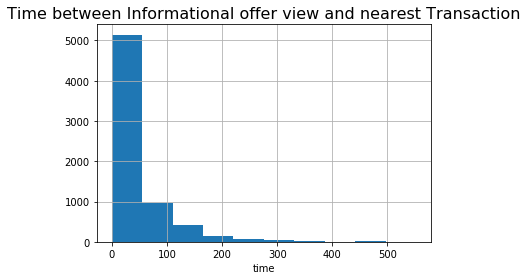

In [28]:
display(inf.loc[(inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction'), 'time_diff_with_sub'].describe())

print('\n\n')

inf.loc[(inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction'), 'time_diff_with_sub'].hist()
plt.title('Time between Informational offer view and nearest Transaction', size=16)
plt.xlabel('time')
plt.show()

In [29]:
threshold = 24

num = sum((inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction') & (inf['time_diff_with_sub'] <= threshold))
den = sum(inf['offer_type'] == 'informational')
print(f'There are {den} informational offers.')
print(f'There are {num} conversions with a response time of {threshold} hours.')
print(f'The Conversion Rate is {round((num / den) * 100, 2)}%.')

There are 9360 informational offers.
There are 3634 conversions with a response time of 24 hours.
The Conversion Rate is 38.82%.


Target features

After studying the CR, we can build the target of our analysis. We will create 3 different columns, one for each type of offer, all 0/1 flags (where 1 is conversion, 0 is not). 

In [30]:
# BOGO target
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'bogo'), 'bogo'] = 0
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'bogo') & (df['time_completed'].isnull() == False), 'bogo'] = 1

# Discount target
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'discount'), 'discount'] = 0
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'discount') & (df['time_completed'].isnull() == False), 'discount'] = 1

In [31]:
# For the informational target, we use the previously created inf dataset, define the logistic, then merge with df
inf.loc[inf['offer_type'] == 'informational', 'info'] = 0
inf.loc[(inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction') & (inf['time_diff_with_sub'] <= threshold), 'info'] = 1

df = pd.merge(df,
              inf.loc[inf['info'].isnull() == False, ['person', 'offer_id', 'time_viewed', 'info', 'sub_time']],
              how='left', on=['person', 'offer_id', 'time_viewed'])

# Let's force time_completed equal to time_transaction for informational data
df.loc[df['info'] == 1, 'time_completed'] = df['sub_time']
df.loc[df['info'] == 1, 'time_transaction'] = df['sub_time']
df.drop('sub_time', 1, inplace=True)

In [32]:
print('There are:')
print('- {} records for BOGO target'.format(sum(df['bogo'].isnull() == False)))
print('- {} records for Discount target'.format(sum(df['discount'].isnull() == False)))
print('- {} records for Informational target'.format(sum(df['info'].isnull() == False)))

There are:
- 21605 records for BOGO target
- 18120 records for Discount target
- 9360 records for Informational target


Customers features

In [33]:
customers = df[['person', 'gender', 'age', 'income', 'member_on']].drop_duplicates()

display(customers.describe(include='all').transpose())

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
person,14815,14815,21c73d53e2a74bb1b4dc172bff2b1aad,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,14815,3,M,8477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,14815,NaN,NaN,NaN,NaN,NaN,54.3931,17.3866,18,42,55,66,101
income,14815,NaN,NaN,NaN,NaN,NaN,65397.8,21598.6,30000,49000,64000,80000,120000
member_on,14815,1707,2017-08-19 00:00:00,39,2013-07-29 00:00:00,2018-07-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can build some new features:

Time feature is registered from a specific T0, which is unknown: we can suppose that it's the nearest month after the membership range, so 2018-08-01. We can create a feature member_from that register the number of months of membership.
We can transform time_viewed in Day dividing by 24. We could not know if day 1 is Monday or Friday, but the model could find some relationship.

In [34]:
from datetime import datetime

def diff_month(d1, d2):
    return (d2.year - d1.year) * 12 + d2.month - d1.month
# Transform hours in days
df['day'] = np.floor(df['time_viewed'] / 24)

# Day of week
df['dow'] = df['day'].mod(7)

# Member from
df['member_from'] = df.apply(lambda x: diff_month(x['member_on'], datetime(2018, 8, 1)), 1)
df.head()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,difficulty,duration,offer_type,pot_reward,age,gender,income,member_on,bogo,discount,info,day,dow,member_from
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.0,168.0,192.0,NaN,NaN,NaN,NaN,"['email', 'mobile', 'social']",0.0,3.0,informational,0.0,33,M,72000.0,2017-04-21,NaN,NaN,0.0,8.0,1.0,16
1,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21,NaN,NaN,NaN,NaN,NaN,16
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,336.0,372.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile']",0.0,4.0,informational,0.0,33,M,72000.0,2017-04-21,NaN,NaN,0.0,15.0,1.0,16
3,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21,NaN,NaN,NaN,NaN,NaN,16
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.0,408.0,456.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile', 'social']",5.0,5.0,bogo,5.0,33,M,72000.0,2017-04-21,0.0,NaN,NaN,19.0,5.0,16


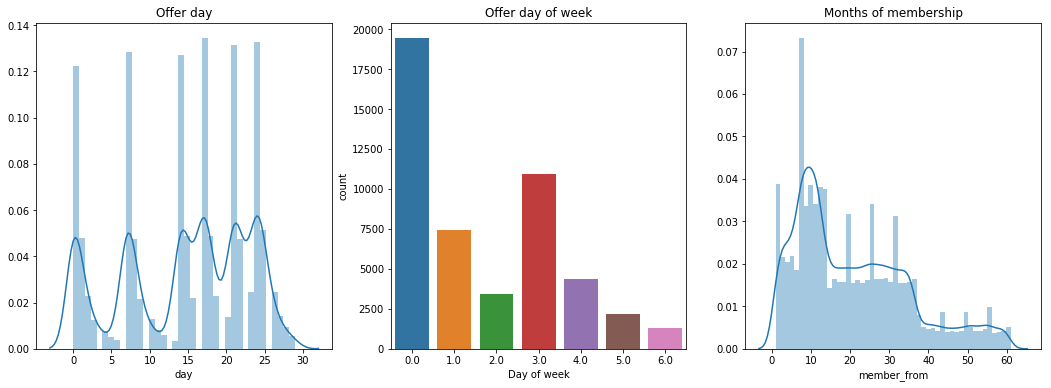

In [35]:
plt.subplots(1, 3, figsize=(18, 6))

plt.subplot(131)
plt.title('Offer day')
sns.distplot(df['day'].dropna())

plt.subplot(132)
plt.title('Offer day of week')
sns.countplot(df['dow'].dropna())
plt.xlabel('Day of week')

plt.subplot(133)
plt.title('Months of membership')
sns.distplot(df['member_from'].dropna())

plt.show()

Now we want to further analyse the customer's behavior looking at "past data". We build a series of new features, and for each record we look at the previous ones for the same customer. These features are:

numerb of transactions
average amount of transaction
number of offers viewed / completed
average reward received
average time from offer reception to view / from offer view to completion

In [36]:
df.reset_index(drop=True, inplace=True)

# First, let's initialize all those features + some temporary ones to save data

# flag if the row has a transaction
df['is_transaction'] = 0 
df.loc[df['time_transaction'].isnull() == False, 'is_transaction'] = 1
# flag if the row has an offer completed
df['is_completed'] = 0
df.loc[df['time_completed'].isnull() == False, 'is_completed'] = 1

df['n_offers_completed'] = 0
df['n_offers_viewed'] = 0
df['n_transactions'] = 0
df['avg_transctions'] = 0
df['avg_reward'] = 0
df['reception_to_view'] = df['time_viewed'] - df['time_received']
df['view_to_completion'] = df['time_completed'] - df['time_viewed']
df['reception_to_view_avg'] = 0
df['view_to_completion_avg'] = 0

# Customer of previous row - to check if she's the same of the actual
df['prev_person'] = df['person'].shift(1)

for i, row in df.iterrows():
    if i % 10000 == 0: # print advancement
        print(i)
    if row['person'] == row['prev_person']: # modify data only if the previous customer is the same as current
        # Add 1 if previous offer was viewed
        df.loc[i, 'n_offers_viewed'] = df.loc[i-1, 'n_offers_viewed'] + (0 if df.loc[i-1, 'offer_type'] == 'transaction' else 1)
        # Add 1 if previous offer was completed
        df.loc[i, 'n_offers_completed'] = df.loc[i-1, 'n_offers_completed'] + df.loc[i-1, 'is_completed']
        # Add previous time from reception to view
        df.loc[i, 'reception_to_view_avg'] = np.nansum((df.loc[i-1, 'reception_to_view_avg'], df.loc[i-1, 'reception_to_view']))
        # Add previous time from view to completion
        df.loc[i, 'view_to_completion_avg'] = np.nansum((df.loc[i-1, 'view_to_completion_avg'], df.loc[i-1, 'view_to_completion']))
        # Add 1 if previous row was a transaction
        df.loc[i, 'n_transactions'] = df.loc[i-1, 'n_transactions'] + df.loc[i-1, 'is_transaction']
        # Add previous amount if previous row was a transaction
        df.loc[i, 'avg_transctions'] = df.loc[i-1, 'avg_transctions'] + (0 if df.loc[i-1, 'is_transaction'] == 0 else df.loc[i-1, 'amount'])
        # Add previous reward if previous row has a reward
        df.loc[i, 'avg_reward'] = np.nansum((df.loc[i-1, 'avg_reward'], df.loc[i-1, 'reward']))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [37]:
# Calculate the averages from the sums
df['reception_to_view_avg'] /= df['n_offers_viewed']
df['view_to_completion_avg'] /= df['n_offers_completed']
df['avg_transctions'] /= df['n_transactions']
df['reception_to_view_avg'].fillna(0, inplace=True)
df['view_to_completion_avg'].fillna(0, inplace=True)
df['avg_transctions'].fillna(0, inplace=True)

In [62]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

In [38]:
df.tail(10)

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,difficulty,duration,offer_type,pot_reward,age,gender,income,member_on,bogo,discount,info,day,dow,member_from,is_transaction,is_completed,n_offers_completed,n_offers_viewed,n_transactions,avg_transctions,avg_reward,reception_to_view,view_to_completion,reception_to_view_avg,view_to_completion_avg,prev_person
150425,ffff82501cea40309d5fdd7edcca4a07,NaN,264.0,NaN,NaN,NaN,264.0,23.32,NaN,NaN,NaN,NaN,transaction,NaN,45,F,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,1,0,2,2,6,14.758333,7.0,NaN,NaN,6.0,39.0,ffff82501cea40309d5fdd7edcca4a07
150426,ffff82501cea40309d5fdd7edcca4a07,NaN,312.0,NaN,NaN,NaN,312.0,16.86,NaN,NaN,NaN,NaN,transaction,NaN,45,F,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,1,0,2,2,7,15.981429,7.0,NaN,NaN,6.0,39.0,ffff82501cea40309d5fdd7edcca4a07
150427,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,354.0,336.0,354.0,384.0,384.0,15.57,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount,2.0,45,F,62000.0,2016-11-25,NaN,1.0,NaN,14.0,0.0,21,1,1,2,2,8,16.091250,7.0,18.0,30.0,6.0,39.0,ffff82501cea40309d5fdd7edcca4a07
150428,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,414.0,408.0,414.0,414.0,414.0,17.55,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount,2.0,45,F,62000.0,2016-11-25,NaN,1.0,NaN,17.0,3.0,21,1,1,3,3,9,16.033333,9.0,6.0,0.0,10.0,36.0,ffff82501cea40309d5fdd7edcca4a07
150429,ffff82501cea40309d5fdd7edcca4a07,NaN,498.0,NaN,NaN,NaN,498.0,13.17,NaN,NaN,NaN,NaN,transaction,NaN,45,F,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,1,0,4,4,10,16.185000,11.0,NaN,NaN,9.0,27.0,ffff82501cea40309d5fdd7edcca4a07
150430,ffff82501cea40309d5fdd7edcca4a07,NaN,504.0,NaN,NaN,NaN,504.0,7.79,NaN,NaN,NaN,NaN,transaction,NaN,45,F,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,1,0,4,4,11,15.910909,11.0,NaN,NaN,9.0,27.0,ffff82501cea40309d5fdd7edcca4a07
150431,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,534.0,504.0,534.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,45,F,62000.0,2016-11-25,0.0,NaN,NaN,22.0,1.0,21,0,0,4,4,12,15.234167,11.0,30.0,NaN,9.0,27.0,ffff82501cea40309d5fdd7edcca4a07
150432,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,582.0,576.0,582.0,NaN,NaN,NaN,NaN,"['web', 'email', 'mobile']",10.0,7.0,discount,2.0,45,F,62000.0,2016-11-25,NaN,0.0,NaN,24.0,3.0,21,0,0,4,5,12,15.234167,11.0,6.0,NaN,13.2,27.0,ffff82501cea40309d5fdd7edcca4a07
150433,ffff82501cea40309d5fdd7edcca4a07,NaN,606.0,NaN,NaN,NaN,606.0,10.12,NaN,NaN,NaN,NaN,transaction,NaN,45,F,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,1,0,4,6,12,15.234167,11.0,NaN,NaN,12.0,27.0,ffff82501cea40309d5fdd7edcca4a07
150434,ffff82501cea40309d5fdd7edcca4a07,NaN,648.0,NaN,NaN,NaN,648.0,18.91,NaN,NaN,NaN,NaN,transaction,NaN,45,F,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,1,0,4,6,13,14.840769,11.0,NaN,NaN,12.0,27.0,ffff82501cea40309d5fdd7edcca4a07


Analysis on features vs Target

In [40]:
def analyse_var(feature):
    plt.subplots(1, 3, figsize=(15, 5))
    if df_dict['bogo'][feature].dtype == 'O' or feature == 'dow':
        func = analyse_cat_var
    else:
        func = analyse_num_var
        
    plt.suptitle(feature, fontsize=20)
    
    plt.subplot(131)
    func(df_dict['bogo'], feature, tgt='bogo', label='BOGO')
    plt.subplot(132)
    func(df_dict['discount'], feature, tgt='discount', label='Discount')
    plt.subplot(133)
    func(df_dict['info'], feature, tgt='info', label='Informational')
        
    plt.show()
    print('\n')

In [43]:
keep_vars = ['gender', 'dow', 'age', 'income', 'day','member_from', 'n_transactions', 'avg_transctions',
             'n_offers_completed', 'n_offers_viewed', 'avg_reward', 'reception_to_view_avg', 'view_to_completion_avg']
df_dict = {}
prefix = 'Capstone_Starbucks'
data_location_dict = {}
for tgt in ['bogo', 'discount', 'info']:
    df_dict[tgt] = df.loc[df[tgt].isnull() == False, [tgt] + keep_vars]
    df_dict[tgt].to_csv(f'./data/{tgt}.csv', index=False, header=False)
    data_location_dict[tgt] = session.upload_data(f'./data/{tgt}.csv', key_prefix=prefix)
for feature in keep_vars:
    analyse_var(feature)

NameError: name 'session' is not defined